In [302]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

import skbio
from skbio import TreeNode
from io import StringIO
from ete3 import Tree
from skbio import diversity 
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa   
from scipy.stats import entropy
from scipy.spatial import procrustes
import warnings
warnings.filterwarnings("ignore")

In [325]:
metadata = pd.read_csv('Thrive_3.0_sample_metadata.txt', sep = '\t')
taxonomy = pd.read_csv('wol_taxonomy.tsv', sep = '\t')
counts = pd.read_csv('merged_filtered_data.csv')

In [327]:
metadata.sample_name = metadata.sample_name.str.replace('X', '').tolist()
metadata = metadata[~metadata['Sample_type'].isna()]
metadata = metadata[metadata['Sample_source'] == 'Participant']

In [328]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
filtered_counts = counts[['OTU.ID'] + intersection(metadata.sample_name, counts.columns.tolist())].set_index('OTU.ID')

In [329]:
metadata = metadata[metadata['sample_name'].isin(filtered_counts.columns)]

In [330]:
metadata.subjectID = metadata.subjectID.astype(str)
metadata.NewSampleID = metadata.subjectID + '_' + metadata.Sample_source + '_' + metadata.visit_day.astype(str) + '_' + metadata.Sample_type

In [331]:
sample_dict = dict(zip(metadata.sample_name, metadata.NewSampleID))
filtered_counts_renamed = filtered_counts.rename(columns = sample_dict).T
filtered_counts_relab = filtered_counts_renamed.div(filtered_counts_renamed.sum(axis=1), axis=0)
filtered_counts_relab[['subjectID', 'sample_source', 'visit_day', 'sample_type']] = filtered_counts_relab.reset_index()['index'].str.split('_', expand=True).values

## PROCRUSTES ANALYSIS 
### BC distance on all

In [8]:
vial_df = filtered_counts_relab[filtered_counts_relab['sample_type'] == 'Vial']
fobt_df = filtered_counts_relab[filtered_counts_relab['sample_type'] == 'FOBT']

In [9]:
vial_pcoa_bc_M = pcoa(squareform(pdist(vial_df.iloc[:, :-4], 'braycurtis'))).samples
fobt_pcoa_bc_M = pcoa(squareform(pdist(fobt_df.iloc[:, :-4], 'braycurtis'))).samples

/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.045706245375810785 and the largest is 2.4771046544410495.
  RuntimeWarning
/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes s

In [10]:
Mx1, Mx2, disparity = procrustes(vial_pcoa_bc_M, fobt_pcoa_bc_M)

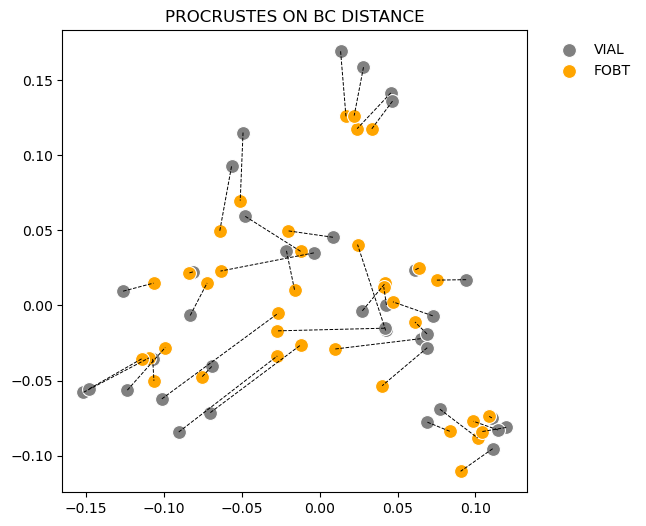

In [24]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = Mx1[:, 0], y = Mx1[:, 1], color='grey', label = 'VIAL', s=100)
sns.scatterplot(x = Mx2[:, 0], y = Mx2[:, 1], color='orange', label = 'FOBT', s=100)

for i in range(len(Mx1)):
    plt.plot([Mx1[i][0], Mx2[i][0]], [Mx1[i][1], Mx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
    
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON BC DISTANCE')
plt.show()

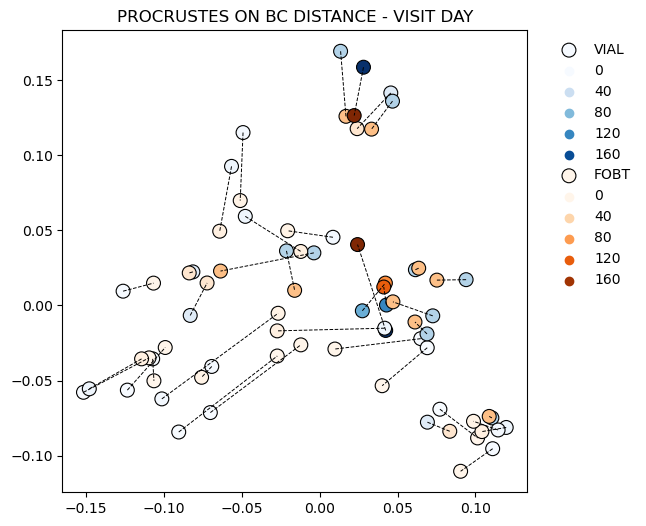

In [25]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = Mx1[:, 0], y = Mx1[:, 1],hue = vial_df.visit_day.astype(float).tolist(), palette = 'Blues', label = 'VIAL', s=100, edgecolor='k')
sns.scatterplot(x = Mx2[:, 0], y = Mx2[:, 1], hue=fobt_df.visit_day.astype(float).tolist(), palette = 'Oranges',label = 'FOBT', s=100, edgecolor='k')

for i in range(len(Mx1)):
    plt.plot([Mx1[i][0], Mx2[i][0]], [Mx1[i][1], Mx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON BC DISTANCE - VISIT DAY')
plt.show()

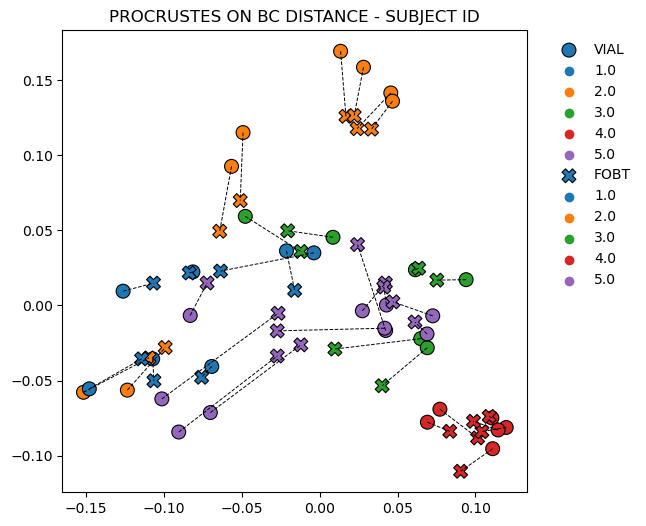

In [26]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = Mx1[:, 0], y = Mx1[:, 1],hue = vial_df.subjectID.tolist(), label = 'VIAL', s=100, edgecolor='k')
sns.scatterplot(x = Mx2[:, 0], y = Mx2[:, 1], hue=fobt_df.subjectID.tolist(), label = 'FOBT', s=100, edgecolor='k', marker='X')

for i in range(len(Mx1)):
    plt.plot([Mx1[i][0], Mx2[i][0]], [Mx1[i][1], Mx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON BC DISTANCE - SUBJECT ID')
plt.show()

## Jaccard distance

In [14]:
vial_binary = vial_df.iloc[:, :-4].copy()
fobt_binary = fobt_df.iloc[:, :-4].copy()

vial_binary[vial_binary>0]=1
fobt_binary[fobt_binary>0]=1

In [15]:
vial_pcoa_jaccard_M = pcoa(squareform(pdist(vial_binary, 'jaccard'))).samples
fobt_pcoa_jaccard_M = pcoa(squareform(pdist(fobt_binary, 'jaccard'))).samples

/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0035998276879040036 and the largest is 2.502350950613786.
  RuntimeWarning
/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes s

In [16]:
jMx1, jMx2, jdisparity = procrustes(vial_pcoa_jaccard_M, fobt_pcoa_jaccard_M)

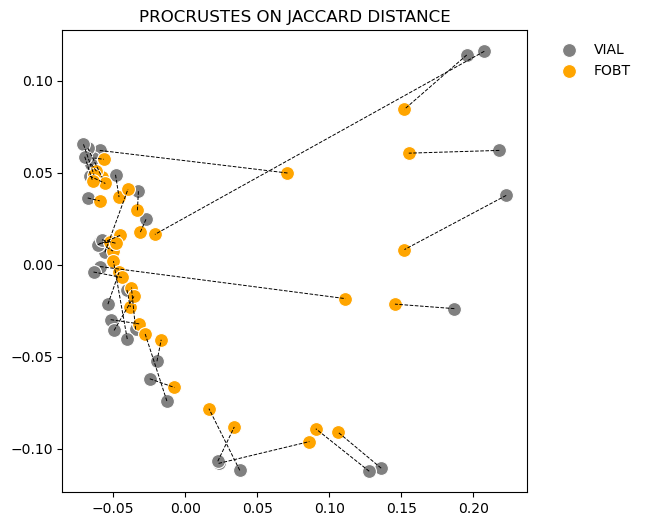

In [21]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = jMx1[:, 0], y = jMx1[:, 1], color='grey', label = 'VIAL', s=100)
sns.scatterplot(x = jMx2[:, 0], y = jMx2[:, 1], color='orange', label = 'FOBT', s=100)

for i in range(len(Mx1)):
    plt.plot([jMx1[i][0], jMx2[i][0]], [jMx1[i][1], jMx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
    
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON JACCARD DISTANCE')
plt.show()

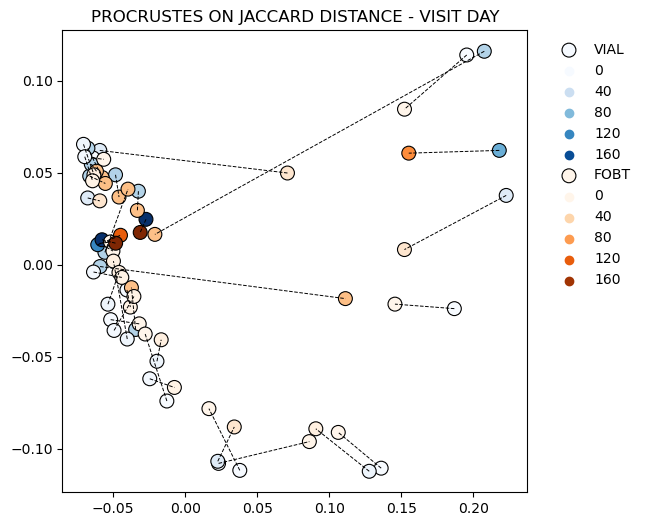

In [22]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = jMx1[:, 0], y = jMx1[:, 1],hue = vial_df.visit_day.astype(float).tolist(), palette = 'Blues', label = 'VIAL', s=100, edgecolor='k')
sns.scatterplot(x = jMx2[:, 0], y =jMx2[:, 1], hue=fobt_df.visit_day.astype(float).tolist(), palette = 'Oranges',label = 'FOBT', s=100, edgecolor='k')

for i in range(len(Mx1)):
    plt.plot([jMx1[i][0], jMx2[i][0]], [jMx1[i][1], jMx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON JACCARD DISTANCE - VISIT DAY')
plt.show()

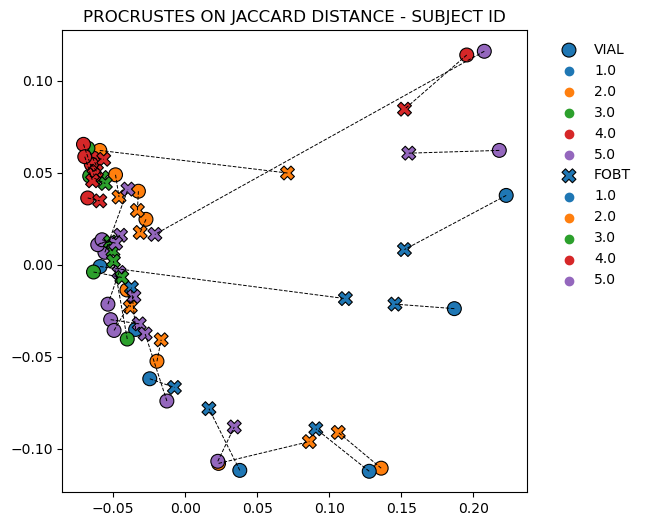

In [23]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = jMx1[:, 0], y = jMx1[:, 1],hue = vial_df.subjectID.tolist(), label = 'VIAL', s=100, edgecolor='k')
sns.scatterplot(x = jMx2[:, 0], y = jMx2[:, 1], hue=fobt_df.subjectID.tolist(), label = 'FOBT', s=100, edgecolor='k', marker='X')

for i in range(len(Mx1)):
    plt.plot([jMx1[i][0], jMx2[i][0]], [jMx1[i][1], jMx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON JACCARD DISTANCE - SUBJECT ID')
plt.show()

### W UNIFRAC

In [78]:
nwk = 'tree.nwk'
ete3_tree = Tree(nwk, format=1)

skbio_tree = TreeNode.read(nwk, 'newick')

leaf_names = ete3_tree.get_leaf_names()
otu_ids = filtered_counts_renamed.columns.values

intersection_of_leaf_names = intersection(leaf_names, otu_ids)
ete3_tree.prune(intersection_of_leaf_names, True)
pruned_skbio_tree = TreeNode.read(StringIO(ete3_tree.write(format=1, format_root_node=True)))

In [89]:
counts_for_unifrac = filtered_counts_renamed[intersection_of_leaf_names]
counts_for_unifrac[['subjectID', 'sample_source', 'visit_day', 'sample_type']] = counts_for_unifrac.reset_index()['index'].str.split('_', expand=True).values

/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [92]:
vial_wu_df = counts_for_unifrac[counts_for_unifrac['sample_type'] == 'Vial']
fobt_wu_df = counts_for_unifrac[counts_for_unifrac['sample_type'] == 'FOBT']

vial_wu = vial_wu_df.iloc[:, :-4].copy()
fobt_wu = fobt_wu_df.iloc[:, :-4].copy()

In [102]:
from joblib import Parallel, delayed

num_samples = vial_wu.shape[0]
results = []
for i in range(num_samples):
    for j in range(num_samples):
        
        distance = weighted_unifrac(vial_wu.iloc[i], vial_wu.iloc[j], intersection_of_leaf_names, pruned_skbio_tree)

        results.append({'s1':i,
                        's2':j, 
                        'distance':distance})

In [111]:
from joblib import Parallel, delayed

def compute_row_distances(i, num_samples, data):
    # Initialize a row of distances
    distances = np.zeros(num_samples)
    for j in range(i + 1, num_samples):  # Start from i+1 to avoid redundant computations
        distance = weighted_unifrac(data.iloc[i], data.iloc[j], intersection_of_leaf_names, pruned_skbio_tree)
        distances[j] = distance
    return distances

num_samples = vial_wu.shape[0]
data = vial_wu  # If preprocessing is needed, it can be done here

# Parallel computation of the upper triangle of the distance matrix
upper_tri_vals = Parallel(n_jobs=-1)(delayed(compute_row_distances)(i, num_samples, data) for i in range(num_samples))

# Construct the full distance matrix
distance_matrix = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        distance_matrix[i, j] = upper_tri_vals[i][j]
        distance_matrix[j, i] = upper_tri_vals[i][j]  # Mirror the upper triangle to the lower triangle

# Convert to DataFrame if you prefer working with pandas
vial_wu_M = pd.DataFrame(distance_matrix)

In [112]:
num_samples = fobt_wu.shape[0]
data = fobt_wu  # If preprocessing is needed, it can be done here

# Parallel computation of the upper triangle of the distance matrix
upper_tri_vals = Parallel(n_jobs=-1)(delayed(compute_row_distances)(i, num_samples, data) for i in range(num_samples))

# Construct the full distance matrix
distance_matrix = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        distance_matrix[i, j] = upper_tri_vals[i][j]
        distance_matrix[j, i] = upper_tri_vals[i][j]  # Mirror the upper triangle to the lower triangle

# Convert to DataFrame if you prefer working with pandas
fobt_wu_M = pd.DataFrame(distance_matrix)

In [115]:
vial_wu_pcoa = pcoa(vial_wu_M).samples
fobt_wu_pcoa = pcoa(fobt_wu_M).samples

wuMx1, wuMx2, wudisparity = procrustes(vial_wu_pcoa, fobt_wu_pcoa)

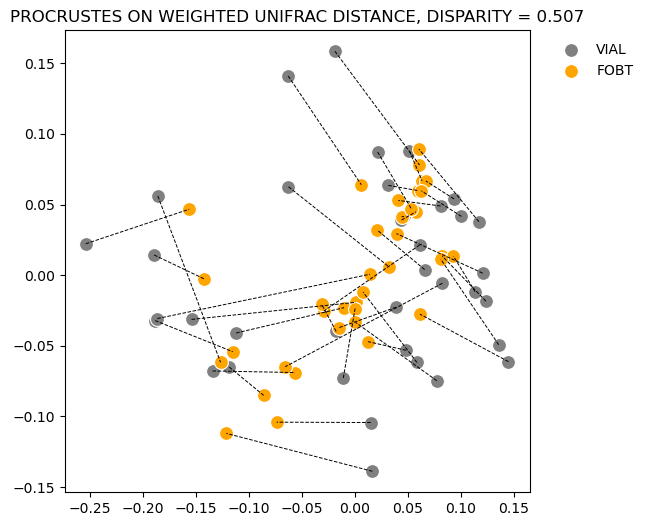

In [118]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = wuMx1[:, 0], y = wuMx1[:, 1], color='grey', label = 'VIAL', s=100)
sns.scatterplot(x = wuMx2[:, 0], y = wuMx2[:, 1], color='orange', label = 'FOBT', s=100)

for i in range(len(wuMx1)):
    plt.plot([wuMx1[i][0], wuMx2[i][0]], [wuMx1[i][1], wuMx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
    
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title(f'PROCRUSTES ON WEIGHTED UNIFRAC DISTANCE, DISPARITY = {np.round(wudisparity, 3)}')
plt.show()

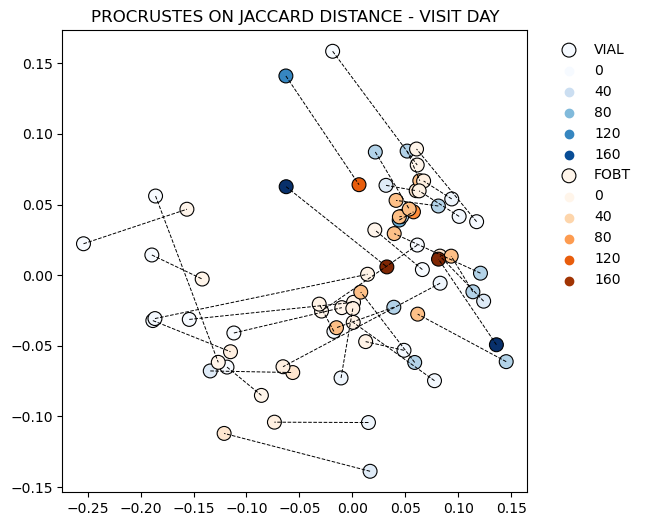

In [119]:
plt.figure(figsize = (6, 6))
sns.scatterplot(x = wuMx1[:, 0], y = wuMx1[:, 1],hue = vial_df.visit_day.astype(float).tolist(), palette = 'Blues', label = 'VIAL', s=100, edgecolor='k')
sns.scatterplot(x = wuMx2[:, 0], y =wuMx2[:, 1], hue=fobt_df.visit_day.astype(float).tolist(), palette = 'Oranges',label = 'FOBT', s=100, edgecolor='k')

for i in range(len(Mx1)):
    plt.plot([wuMx1[i][0], wuMx2[i][0]], [wuMx1[i][1], wuMx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON JACCARD DISTANCE - VISIT DAY')
plt.show()

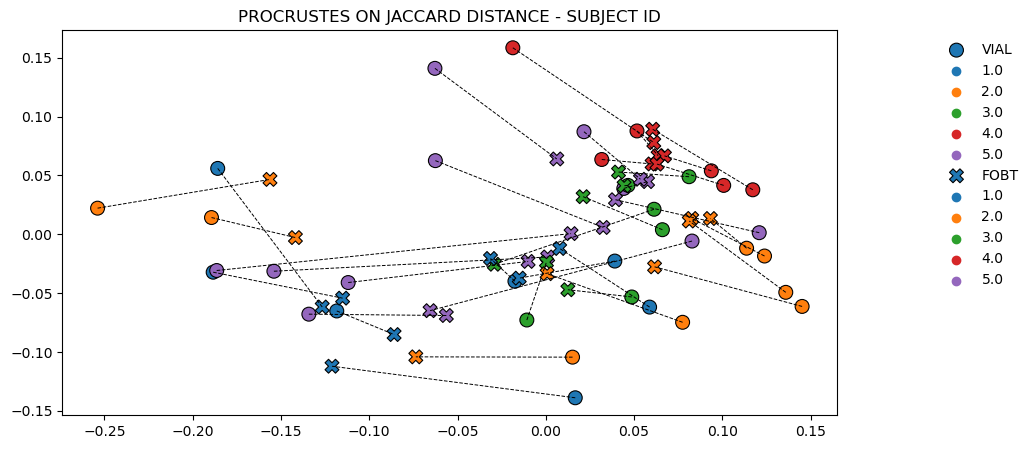

In [122]:
plt.figure(figsize = (10, 5))
sns.scatterplot(x = wuMx1[:, 0], y = wuMx1[:, 1],hue = vial_df.subjectID.tolist(), label = 'VIAL', s=100, edgecolor='k')
sns.scatterplot(x = wuMx2[:, 0], y =wuMx2[:, 1], hue=fobt_df.subjectID.tolist(), label = 'FOBT', s=100, edgecolor='k', marker='X')

for i in range(len(Mx1)):
    plt.plot([wuMx1[i][0], wuMx2[i][0]], [wuMx1[i][1], wuMx2[i][1]], 'black', linestyle='--', lw=.7)  # Connect with dashed gray lines
plt.legend(bbox_to_anchor = (1.25, 1), edgecolor='white')
plt.title('PROCRUSTES ON JACCARD DISTANCE - SUBJECT ID')
plt.show()

In [192]:
num_samples = counts_for_unifrac.shape[0]
data = counts_for_unifrac.iloc[:, :-4]  # If preprocessing is needed, it can be done here

# Parallel computation of the upper triangle of the distance matrix
upper_tri_vals = Parallel(n_jobs=-1)(delayed(compute_row_distances)(i, num_samples, data) for i in range(num_samples))

# Construct the full distance matrix
distance_matrix = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        distance_matrix[i, j] = upper_tri_vals[i][j]
        distance_matrix[j, i] = upper_tri_vals[i][j]  # Mirror the upper triangle to the lower triangle

# Convert to DataFrame if you prefer working with pandas
wu_M = pd.DataFrame(distance_matrix)

In [129]:
wu_pcoa = pcoa(wu_M).samples

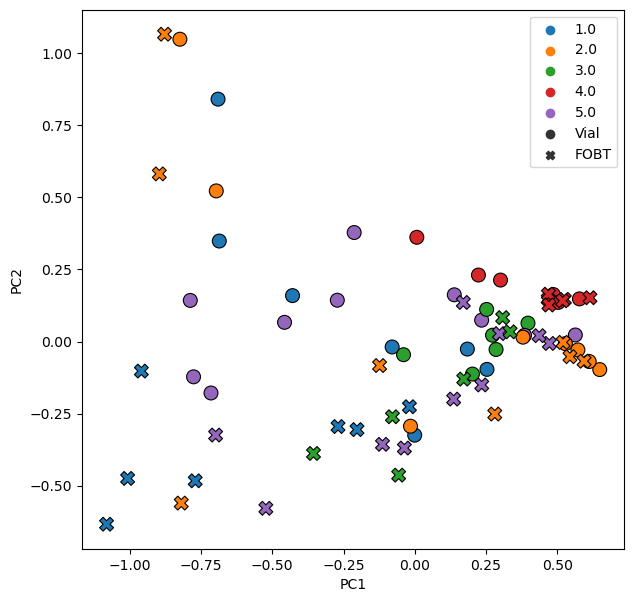

In [142]:
plt.figure(figsize = (7,7))

sns.scatterplot(x=wu_pcoa.PC1, y=wu_pcoa.PC2, s=100, edgecolor='k', style = counts_for_unifrac.sample_type.values, hue = counts_for_unifrac.subjectID.values)
plt.show()

### ALPHA DIVERSITY

In [262]:
alpha_df = filtered_counts_relab.iloc[:, :-4]

In [263]:
res = []
for i in range(alpha_df.shape[0]):
    try:
        shannon = entropy(alpha_df.iloc[i])
        res.append({'s':alpha_df.index[i],
                    'shannon':shannon})
    except: pass

In [266]:
shannon_df = pd.DataFrame(res)
shannon_df = shannon_df.set_index('s')
shannon_df = pd.merge(shannon_df, filtered_counts_relab.sample_type, left_index=True, right_index=True)
shannon_df = pd.merge(shannon_df, filtered_counts_relab.visit_day, left_index=True, right_index=True)
shannon_df = pd.merge(shannon_df, filtered_counts_relab.subjectID, left_index=True, right_index=True)

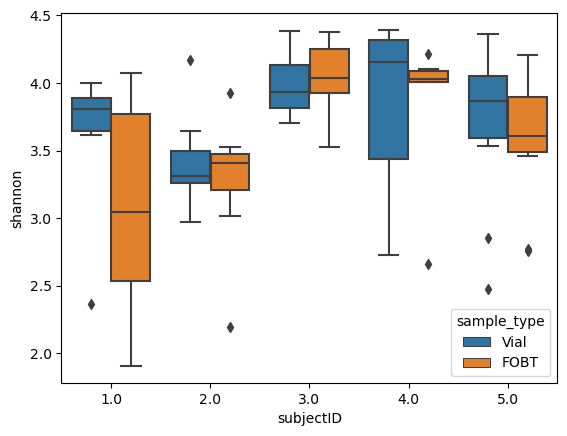

In [274]:
sns.boxplot(data = shannon_df, x = 'subjectID', y = 'shannon', hue = 'sample_type')
plt.show()

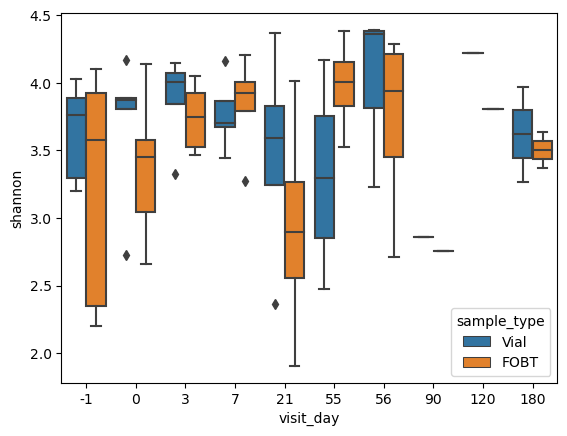

In [281]:
sns.boxplot(data = shannon_df, x = shannon_df['visit_day'].astype(int), y = 'shannon', hue = 'sample_type')
plt.show()

In [282]:
alpha_binary = alpha_df.copy()
alpha_binary[alpha_binary>0]=1

In [293]:
n_features = alpha_binary.sum(axis=1).reset_index().rename({0:"N_features"}, axis=1).set_index('index')
shannon_df = pd.merge(n_features, shannon_df, left_index=True, right_index=True)

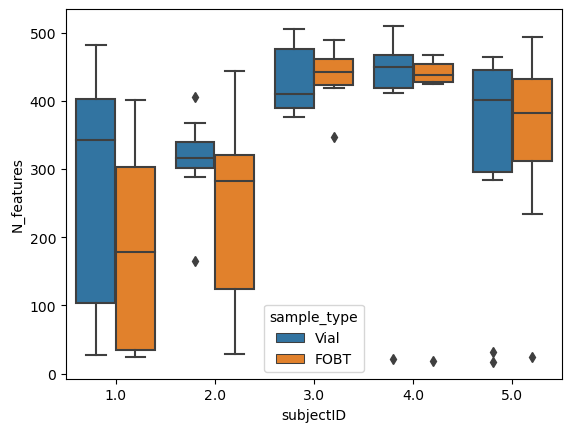

In [294]:
sns.boxplot(data = shannon_df, x = 'subjectID', y = 'N_features', hue = 'sample_type')
plt.show()

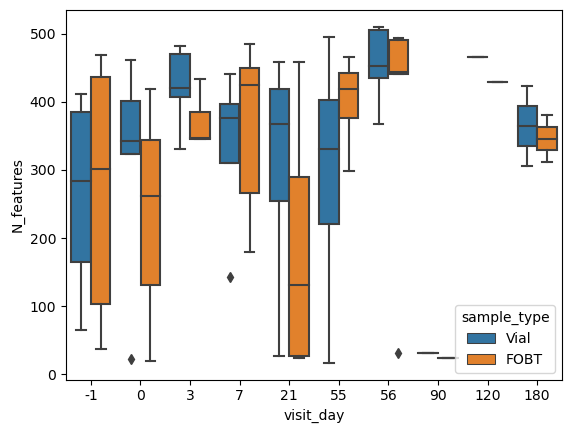

In [295]:
sns.boxplot(data = shannon_df, x = shannon_df['visit_day'].astype(int), y = 'N_features', hue = 'sample_type')
plt.show()

### DO WE SEE BACTERIA CONNECTED TO WEIGHT GAIN IN VIAL AND FOBT SAMPLES

In [333]:
metadata = metadata[metadata['visit_day'] != 'Caregiver']#.dropna(axis=1)bmi

In [324]:
metadata.columns.values

array(['sample_name', 'associated_vial', 'Sample_type', 'Sample_source',
       'subjectID', 'visit_day', 'Collection_Date', 'scr_random_group',
       'visit_date', 'child_age_months', 'fs_missedmeal', 'fs_enough',
       'fs_unable', 'fs_limited', 'fs_unwanted', 'fs_fewer', 'fs_hungry',
       'fs_daynight', 'se_meals_eaten', 'fs_livestock', 'fs_pets___Cats',
       'fs_daycare', 'fs_diet_milk', 'fs_diet_breastmilk',
       'fs_diet_cereal', 'fs_milk_num', 'fs_diet_seafood',
       'fs_diet_roots', 'fs_diet_veggies', 'fs_diet_fruits',
       'fs_diet_meat', 'fs_diet_eggs', 'fs_diet_pulses', 'fs_diet_fats',
       'fs_diet_sugars', 'fs_diet_miscellaneous', 'fs_diet_unknown',
       'fs_cereal_num', 'fs_sugars_num',
       'baseline_hospitalized_1month_pre_baseline',
       'baseline_meds_antibiotics_2months_pre_baseline',
       'baseline_meds_7days_pre_baseline', 'child_dob', 'scr_child_race',
       'scr_care_when_primary_childcaring', 'scr_care_primary_age_yr',
       'scr_care_pri

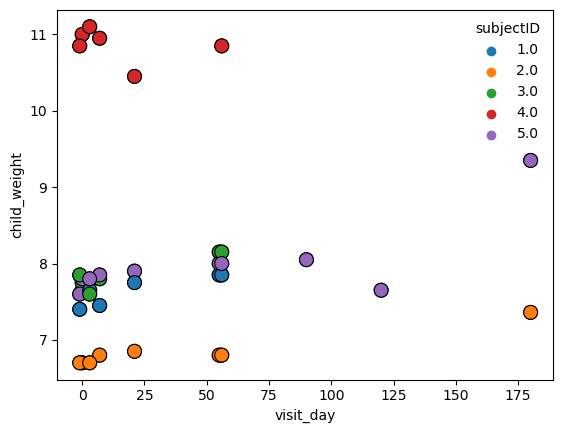

In [361]:
sns.scatterplot(x = metadata.visit_day.astype(float), y = metadata.child_weight, hue = metadata.subjectID,s=100, edgecolor='k')
plt.legend(edgecolor = 'w', title='subjectID')
plt.savefig('child_weight.png')
plt.show()

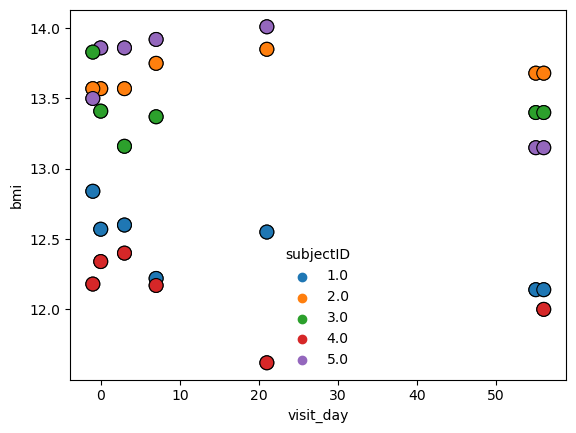

In [358]:
sns.scatterplot(x = metadata.visit_day.astype(float), y = metadata.bmi, hue = metadata.subjectID,s=100, edgecolor='k')
plt.legend(edgecolor = 'w', title='subjectID')
plt.savefig('bmi.png')
plt.show()